# Siamese Neural Networks
Recognize images of icebergs from images of ships. 
These images were taken from space with a Sentinel-4 satellite. The goal was to create the most accurate neural network to differentiate them. However, neural networks usually only work well with A LOT of data, and I constrained you guys to 1000 examples to train on. That seems like a lot, but a CONVENTIONAL neural network needs more data. However, we are going to make a special kind of neural network: *Siamese Network*. This special network is used for face recognition and few-shot learning(learning from few examples). Let's get started by importing the usual liraries:

In [3]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D,Activation, Dropout, ZeroPadding2D
from keras.models import Model, Sequential
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import Adam,RMSprop
from skimage.io import imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

Using TensorFlow backend.


## Load the Data


In [4]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
project_path = "/content/drive/My Drive/Resi10/"

In [8]:
npz = np.load(project_path+'input_data.npz')
X_train = npz['X_train']
Y_train = npz['Y_train']
del npz
print ('We have {} examples to work with'.format(Y_train.shape[0]-1000))

We have 3113 examples to work with


## Check the data

Load some of the images to observe how your data look like.

In [9]:
X_train.shape

(4113, 75, 75, 3)

W0722 04:45:26.305594 140458231265152 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0722 04:45:26.309682 140458231265152 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0722 04:45:26.315485 140458231265152 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


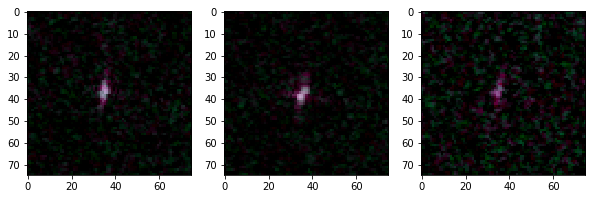

In [10]:
 fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
 ax1.imshow(X_train[0])
 ax2.imshow(X_train[20])
 ax3.imshow(X_train[1000])



In [11]:
np.isnan(X_train).any()

False

In [12]:
np.isnan(Y_train).any()

False

# Creating the structure of Siamese Network

You just need to break it into some steps:
1. 2 Inputs for each images
2. Creating a network which both images will go through individually
3. Couple the network to each input
4. Calculate the L1 distance between them. Just (x1,y1)-(x2,y2)
5. 1 Added layer that will say 1 if they are the same and 0 if they are different

# Create two Inputs for each image - left_input and right_input
Hint - use Input Function in Keras and keep the shape to be 75,75,3

In [0]:
img_h = 75
img_w = 75

In [0]:
input_shape=(img_h, img_w, 3)

In [0]:
input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# Create a base Network in which both images will go through individually.

Hint - Use Sequential Model in Keras with convolution layers, Maxpooling Layers, Flatten Layer and Denser Layer with appropriate activation functions.
Name the network as base_network

In [0]:
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Conv2D(96, kernel_size=(3, 3), activation='relu', name='conv2_1')(input)
    x = MaxPooling2D((3,3), strides=(2, 2))(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)

In [0]:
# network definition
base_network = create_base_network(input_shape)

# Process the left and right inputs to the same Base Network(base_network)

In [0]:

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)

In [0]:
processed_b = base_network(input_b)

# Get the L1 Distance layer between the 2 processed encodings (processed_a and processed_b)
Hint - You can use Lambda function for this.

In [0]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [0]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [0]:
# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

# Add the prediction layer in the end and create the Siamese Network using Model function.

In [53]:
model = Model([input_a, input_b], output=distance)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model([<tf.Tenso..., outputs=Tensor("la...)`
  """Entry point for launching an IPython kernel.


# Define the Optimizer Adam and Compile the Siamese Model.

In [0]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    Source: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    
    Explanation:
    When ytrue is 1, that means the sample are duplicates of each other, 
    so the Euclidean distance (ypred) between their outputs must be minimized.
    So the loss is taken as the square of that Euclidean distance itself - K.square(y_pred).
    When ytrue is 0, i.e. the samples are not duplicates, then the Euclidean distance 
    between them must be maximized, at least to the margin. So the loss to be minimized
    is the difference of the margin and the Euclidean distance - (margin - y_pred).
    If the Euclidean distance (ypred) is already greater than the margin, 
    then nothing is to be learned, so the loss is made to be zero in 
    that case by saying K.maximum(margin - y_pred, 0).
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [0]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [0]:
# compile model using Adam Optimizer and Contrastive loss function defined above
adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)
model.compile(loss=contrastive_loss, optimizer=adam, metrics=[accuracy])

# Show the Summary of your Siamese Network

In [57]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 128)          63769856    input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 1)            0           model_3[1][0]                    
          

# Creating the Pair of Images to train on

It's not time to train though. We still have to create pairs of images to train on. There will be Positive(the same class) or Negative(different classes) for outputs. Let's construct this dataset. It is recommended that there are equal amounts positive and negative.

In [58]:
# First let's separate the dataset from 1 matrix to a list of matricies
image_list = np.split(X_train[:1000],1000)
label_list = np.split(Y_train[:1000],1000)
print(len(image_list))

left_input = []
right_input = []
targets = []

#Number of pairs per image
pairs = 5
#Let's create the new dataset to train on
for i in range(len(label_list)):
    for _ in range(pairs):
        compare_to = i
        while compare_to == i: #Make sure it's not comparing to itself
            compare_to = random.randint(0,999)
        left_input.append(image_list[i])
        right_input.append(image_list[compare_to])
        if label_list[i] == label_list[compare_to]:# They are the same
            targets.append(1.)
        else:# Not the same
            targets.append(0.)
            
left_input = np.squeeze(np.array(left_input))
right_input = np.squeeze(np.array(right_input))
targets = np.squeeze(np.array(targets))

iceimage = X_train[101]
test_left = []
test_right = []
test_targets = []

for i in range(Y_train.shape[0]-1000):
    test_left.append(iceimage)
    test_right.append(X_train[i+1000])
    test_targets.append(Y_train[i+1000])

test_left = np.squeeze(np.array(test_left))
test_right = np.squeeze(np.array(test_right))
test_targets = np.squeeze(np.array(test_targets))

1000


Now we have a lot more examples.
Now we have pairs x 1000 examples to train the network on. 
Each side will have an input of an image and the output will be one if they are the same and zero if not.

# Train the Siamese train on left and right input image pairs created and validate it by test pairs.

In [30]:
test_left.shape

(3113, 75, 75, 3)

In [31]:
len(test_left)

3113

In [32]:
right_input.shape

(5000, 75, 75, 3)

In [33]:
test_targets.shape

(3113,)

In [34]:
np.isnan(left_input).any()

False

In [35]:
np.isnan(right_input).any()

False

In [59]:
results = model.fit([left_input, right_input], targets,
                    batch_size=32,
                    epochs=10,
                    validation_data=([test_left, test_right], test_targets))

Train on 5000 samples, validate on 3113 samples
Epoch 1/10
5000/5000 [==============================] - 368s 74ms/step - loss: 0.4719 - accuracy: 0.6124 - val_loss: 0.2494 - val_accuracy: 0.5827
Epoch 2/10
5000/5000 [==============================] - 365s 73ms/step - loss: 0.0770 - accuracy: 0.9260 - val_loss: 0.1393 - val_accuracy: 0.8089
Epoch 3/10
5000/5000 [==============================] - 362s 72ms/step - loss: 0.0210 - accuracy: 0.9928 - val_loss: 0.1694 - val_accuracy: 0.7449
Epoch 4/10
5000/5000 [==============================] - 362s 72ms/step - loss: 0.0162 - accuracy: 0.9956 - val_loss: 0.1520 - val_accuracy: 0.7767
Epoch 5/10
5000/5000 [==============================] - 360s 72ms/step - loss: 0.0134 - accuracy: 0.9974 - val_loss: 0.1399 - val_accuracy: 0.7996
Epoch 6/10
5000/5000 [==============================] - 362s 72ms/step - loss: 0.0103 - accuracy: 0.9988 - val_loss: 0.1335 - val_accuracy: 0.8137
Epoch 7/10
5000/5000 [==============================] - 362s 72ms/step

In [0]:
# compute final accuracy on training and test sets
y_pred = model.predict([left_input, right_input])
train_acc = compute_accuracy(targets, y_pred)
y_pred = model.predict([test_left, test_right])
test_acc = compute_accuracy(test_targets, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * train_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * test_acc))

In [0]:
print('hhj')